# Preproces AIS data

Load data for a specific region and time period and extract trajectories of ships.

## Load data

Our AIS data is stored at a Postgres server at our institute's server.
To access the data a GraphQL API is provided through [Hasura](https://hasura.io/).


In [1]:
# connect to api
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import pandas as pd

from MapRevMoenk import *

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="http://172.24.0.4:8080/v1/graphql",
    headers={'content-type': 'application/json',
        'x-hasura-admin-secret': 'aaasdsdndsfvksdsd'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

# Provide a GraphQL query
query = gql(
    """
    query MyQuery(
  $lteTimeString: String!,
  $gteTimeString: String!,
  $bound_bottom: float8!,
  $bound_top: float8!,
  $bound_left: float8!,
  $bound_right: float8!) {
      ais(limit: 100000, where: {
        datetime: {_lte: $lteTimeString, _gte: $gteTimeString},
        lon: {_is_null: false, _gte: $bound_left, _lte: $bound_right},
        lat: {_is_null: false, _gte: $bound_bottom, _lte: $bound_top}
        }) {
            mmsi
            datetime
            lat
            lon
            speed
            heading
            }
    }
"""
)

params = {"lteTimeString": "2022-04-10 14:00:00+00", "gteTimeString": "2022-04-10 13:00:00+00", "bound_right": BOUND_RIGHT, "bound_left": BOUND_LEFT, "bound_top": BOUND_TOP, "bound_bottom": BOUND_BOTTOM}
print(params)

# Execute the query on the transport
result = await client.execute_async(query, variable_values=params)
df = pd.DataFrame(result['ais'])

{'lteTimeString': '2022-04-10 14:00:00+00', 'gteTimeString': '2022-04-10 13:00:00+00', 'bound_right': 10.190433, 'bound_left': 10.141767, 'bound_top': 54.352733, 'bound_bottom': 54.325583}


In [2]:
# Convert in env coordinates
from FerryGymEnv import FerryGymEnv
env = FerryGymEnv()
# iterate though rows
for index, row in df.iterrows():
    # get x,y from env.convertLatonInEnvCoordinates
    x, y = env.convertLatLotInEnvCoordinates(row['lat'], row['lon'])
    # set x,y in df
    df.at[index, 'x'] = x
    df.at[index, 'y'] = y



10.153217 54.332717
(267.0396169810494, 799.1655248618413)
10.1764 54.351917
(807.7190440964695, 32.579889502778606)
10.1765 54.351917
(810.0512678255976, 32.579889502778606)
3018.942258399647
3153.736130301061
(2.778622141234415, 2.785002083394508)
10.135562031373412 54.31517454449041
10.136237462320427 54.31485346032062
10.136910833971342 54.315898689737935
10.13709679238673 54.31603925850428
10.137477044954723 54.3158731609153
10.138855888653781 54.31694274933087
10.13912198788603 54.31708456966847
10.139119993582428 54.317118996474484
10.139181322592776 54.31709013900889
10.138973490356877 54.31690537492929
10.139394331636142 54.31670014279536
10.14077535724937 54.31771875955658
10.140531979195657 54.31780804085284
10.140571536212521 54.31785417264078
10.140836747486901 54.31774501410247
10.141709722702219 54.318447202353475
10.142100001139625 54.31869916849877
10.142162695156005 54.31867261396661
10.141970273834888 54.31851318080415
10.14272783908382 54.31813816329061
10.142647951

/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


10.190433 54.325583


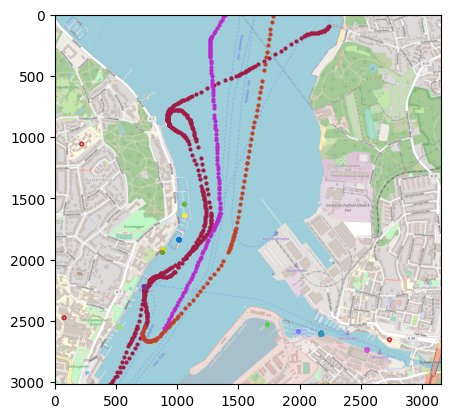

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# add plot 
max_x, max_y = env.convertLatLotInEnvCoordinates(BOUND_BOTTOM, BOUND_RIGHT)
axis_measure = [0, max_x, 0, max_y]
plt.axis(axis_measure)

img = plt.imread("15-50-rev-moenk.png")
plt.imshow(img, extent=axis_measure, origin='lower')
plt.gca().invert_yaxis()

# for every mmsi in df plot the trajectory
for mmsi in df['mmsi'].unique():
    # distinct color for mmsi
    color = np.random.rand(3,)
    # iterate though rows for mmsi starting with smallest time
    for index, row in df[df['mmsi'] == mmsi].sort_values(by=['datetime']).iterrows():
        # plot dashed line
        plt.plot(row.x, row.y, color=color, marker='o', linestyle='dashed',
            linewidth=1, markersize=2)

    



In [4]:
# interpolate_trajectories to generate position data for every second

#
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
df_grouped = df.groupby(['mmsi'])
df_resampled = df_grouped.resample('1S', on='datetime').mean()

df_resampled.head()

# df_interpol = df_grouped.apply(lambda g: .interpolate(method='cubicspline')
# type(df_interpol)
# df_interpol.head()


mmsi        lat      lon  speed  \
mmsi      datetime                                                            
211179240 2022-04-10 13:42:51+00:00  211179240.0  54.352733  10.1632    4.9   
          2022-04-10 13:42:52+00:00          NaN        NaN      NaN    NaN   
          2022-04-10 13:42:53+00:00          NaN        NaN      NaN    NaN   
          2022-04-10 13:42:54+00:00          NaN        NaN      NaN    NaN   
          2022-04-10 13:42:55+00:00          NaN        NaN      NaN    NaN   

                                     heading            x    y  
mmsi      datetime                                              
211179240 2022-04-10 13:42:51+00:00    217.0  1388.937379  0.0  
          2022-04-10 13:42:52+00:00      NaN          NaN  NaN  
          2022-04-10 13:42:53+00:00      NaN          NaN  NaN  
          2022-04-10 13:42:54+00:00      NaN          NaN  NaN  
          2022-04-10 13:42:55+00:00      NaN          NaN  NaN

In [6]:
df_interpol = df_resampled.interpolate()
df_interpol.head()

mmsi        lat        lon  speed  \
mmsi      datetime                                                              
211179240 2022-04-10 13:42:51+00:00  211179240.0  54.352733  10.163200    4.9   
          2022-04-10 13:42:52+00:00  211179240.0  54.352715  10.163182    4.9   
          2022-04-10 13:42:53+00:00  211179240.0  54.352696  10.163163    4.9   
          2022-04-10 13:42:54+00:00  211179240.0  54.352678  10.163145    4.9   
          2022-04-10 13:42:55+00:00  211179240.0  54.352660  10.163127    4.9   

                                     heading            x         y  
mmsi      datetime                                                   
211179240 2022-04-10 13:42:51+00:00    217.0  1388.937379  0.000000  
          2022-04-10 13:42:52+00:00    216.9  1387.751471  2.034867  
          2022-04-10 13:42:53+00:00    216.8  1386.565564  4.069734  
          2022-04-10 13:42:54+00:00    216.7  1385.379657  6.104601  
          2022-04-10 13:42:55+00:00    216.6  1384.193749  8.139469

In [8]:
df =  df_interpol.reset_index(level=['datetime'])
# add new index column numbering the rows
df['index'] = range(1, len(df) + 1)
df.set_index('index', inplace=True)
df.head()


,datetime,mmsi,lat,lon,speed,heading,x,y
index,,,,,,,,
1,2022-04-10 13:42:51+00:00,211179240.0,54.352733,10.163200,4.9,217.0,1388.937379,0.000000
2,2022-04-10 13:42:52+00:00,211179240.0,54.352715,10.163182,4.9,216.9,1387.751471,2.034867
3,2022-04-10 13:42:53+00:00,211179240.0,54.352696,10.163163,4.9,216.8,1386.565564,4.069734
4,2022-04-10 13:42:54+00:00,211179240.0,54.352678,10.163145,4.9,216.7,1385.379657,6.104601
5,2022-04-10 13:42:55+00:00,211179240.0,54.352660,10.163127,4.9,216.6,1384.193749,8.139469


In [9]:
df['mmsi'].unique()

array([2.1117924e+08, 2.1121247e+08, 2.1121425e+08, 2.1121657e+08,
       2.1122312e+08, 2.1128830e+08, 2.1135016e+08, 2.1139128e+08,
       2.1140851e+08, 2.1140993e+08, 2.1146226e+08, 2.1162987e+08,
       2.1172881e+08, 2.1175618e+08, 2.1833400e+08])

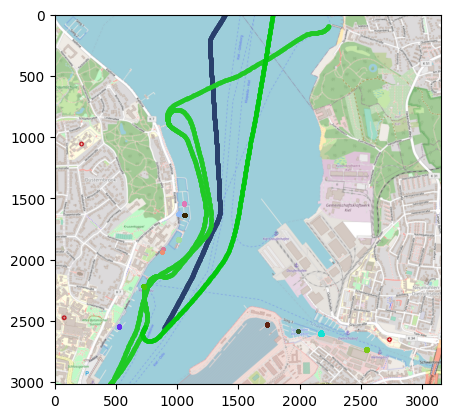

In [10]:


# add plot
img = plt.imread("15-50-rev-moenk.png")
plt.imshow(img, extent=axis_measure, origin='lower')
plt.gca().invert_yaxis()
# for every mmsi in df plot the trajectory
for mmsi in df['mmsi'].unique():
    # distinct color for mmsi
    color = np.random.rand(3,)
    # iterate though rows for mmsi starting with smallest time
    for index, row in df[df['mmsi'] == mmsi].sort_values(by=['datetime']).iterrows():
        # plot dashed line
        plt.plot(row.x, row.y, color=color, marker='o', linestyle='dashed',
            linewidth=1, markersize=2)


In [28]:
# save data with pickle
df.to_pickle('../data/rev-moenk/2022-04-10-13->14II.pkl')

In [1]:
# load data
import os
import pandas as pd

df = pd.read_pickle('../data/rev-moenk/2022-04-10-13->14II.pkl')

In [14]:
# Loop throgh time and get data for every second

import datetime
startingTime = datetime.datetime(2022, 4, 10, 13, 0, 0)
# get all position data at starting time
df_interpol.head()

df_datetime = df.groupby('datetime')
df_datetime.get_group('2022-04-10 13:42:51+00:00')
# loop through all mmsi and get all position data
time = datetime.datetime(2022, 4, 10, 13, 00, 1)
timedelta = datetime.timedelta(seconds=1)
time = time + timedelta
print(time.strftime('%Y-%m-%d %H:%M:%S'))
for row in df_datetime.get_group(time.strftime('%Y-%m-%d %H:%M:%S')+'+00:00').iterrows():
    print(row[1]['mmsi'])
    print(row[1]['x'])
    print(row[1]['y'])
    print(row[1]['speed'])
    print(row[1]['heading'])
    print('\n')

NameError: name 'df_interpol' is not defined

## Preprocess data

* add speed
* add acceleration
* add direction 

In [5]:
import datetime

# calculate current speed and save in new column
timedelta = datetime.timedelta(seconds=1)

df['dist_x'] = df['x'].diff().fillna(0.)
df['dist_y'] = df['y'].diff().fillna(0.)
df['dist'] = (df['dist_x']**2 + df['dist_y']**2)**0.5
# add column for speed in m/s (speed column is in knots)
speed_calculated = df['dist'] / timedelta.total_seconds()
df['speed_calculated'] = speed_calculated 
# filter speeds over 30 m/s and set to speed from AIS
df['speed_calculated'] = speed_calculated.where(speed_calculated < 30, df['speed'] * 0.514444)

In [6]:
# calculate acceleration and save in new column
acceleration = df['speed_calculated'].diff().fillna(0.)
df['acceleration'] = acceleration / timedelta.total_seconds()

,datetime,mmsi,lat,lon,speed,heading,x,y,speed_calculated,acceleration,direction,dist_x,dist_y,dist_X,dist_Y,dist
index,,,,,,,,,,,,,,,,
1,2022-04-10 13:42:51+00:00,211179240.0,54.352733,10.163200,4.9,217.0,1388.937379,0.000000,0.00000,0.000000e+00,90.0,0.000000,0.000000,0.000000,0.000000,0.00000
2,2022-04-10 13:42:52+00:00,211179240.0,54.352715,10.163182,4.9,216.9,1387.751471,2.034867,2.35522,2.355220e+00,NaN,-1.185907,2.034867,-1.185907,2.034867,2.35522
3,2022-04-10 13:42:53+00:00,211179240.0,54.352696,10.163163,4.9,216.8,1386.565564,4.069734,2.35522,1.141309e-13,NaN,-1.185907,2.034867,-1.185907,2.034867,2.35522
4,2022-04-10 13:42:54+00:00,211179240.0,54.352678,10.163145,4.9,216.7,1385.379657,6.104601,2.35522,-1.141309e-13,NaN,-1.185907,2.034867,-1.185907,2.034867,2.35522
5,2022-04-10 13:42:55+00:00,211179240.0,54.352660,10.163127,4.9,216.6,1384.193749,8.139469,2.35522,0.000000e+00,NaN,-1.185907,2.034867,-1.185907,2.034867,2.35522


In [7]:
# calculate direction and save in new column
import numpy as np

vector_1 = np.repeat([(0,1)], len(df.index), axis=0)
vector_2 = df[['dist_x', 'dist_y']]
# calculate angle between vectors piecewise
directions = []
for index, a, b in zip(range(1, len(df.index) +1), vector_1, vector_2.values):

    # if speed is below 0.001 m/s then set direction to heading as a really slow speed is most likely a position change introduced by variance in AIS data
    if df.loc[[index]].speed_calculated.item() < 0.05:
        directions.append(df.loc[[index]].heading.item() % 360)
    else:
        # inverse y component of second vector as y is inverted in image
        b[1] = -1 * b[1]
        dot = np.dot(a/np.linalg.norm(a), b/np.linalg.norm(b))
        angels = np.degrees(np.arccos(dot))
        np.rint(angels)
        directions.append(angels)

df['direction'] = directions
df.head()


,datetime,mmsi,lat,lon,speed,heading,x,y,speed_calculated,acceleration,direction,dist_x,dist_y,dist_X,dist_Y,dist
index,,,,,,,,,,,,,,,,
1,2022-04-10 13:42:51+00:00,211179240.0,54.352733,10.163200,4.9,217.0,1388.937379,0.000000,0.00000,0.000000e+00,217.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,2022-04-10 13:42:52+00:00,211179240.0,54.352715,10.163182,4.9,216.9,1387.751471,2.034867,2.35522,2.355220e+00,149.766644,-1.185907,2.034867,-1.185907,2.034867,2.35522
3,2022-04-10 13:42:53+00:00,211179240.0,54.352696,10.163163,4.9,216.8,1386.565564,4.069734,2.35522,1.141309e-13,149.766644,-1.185907,2.034867,-1.185907,2.034867,2.35522
4,2022-04-10 13:42:54+00:00,211179240.0,54.352678,10.163145,4.9,216.7,1385.379657,6.104601,2.35522,-1.141309e-13,149.766644,-1.185907,2.034867,-1.185907,2.034867,2.35522
5,2022-04-10 13:42:55+00:00,211179240.0,54.352660,10.163127,4.9,216.6,1384.193749,8.139469,2.35522,0.000000e+00,149.766644,-1.185907,2.034867,-1.185907,2.034867,2.35522


In [9]:
# add direction_change column
direction_change = df['direction'].diff().fillna(0.)
df['direction_change'] = direction_change

In [50]:
# save data with pickle
df.to_pickle('../data/rev-moenk/training/2022-04-10-13->14.pkl')

## Generate neighborhood images

In [20]:
from gym.envs.registration import register
from FerryGymEnv import FerryGymEnv
import gym
import datetime

kwargs = dict(
    generate_training_data=True,
    data_path='../data/rev-moenk/training/2022-04-10-13->14.pkl',
    startingTime=datetime.datetime(2022, 4, 10, 13, 0, 1),
)


register(
    id="FerryGym-v0-training",
    entry_point="FerryGymEnv:FerryGymEnv",
    kwargs=kwargs
)

print('Building the environment (loading data, if any)')
env = gym.make('FerryGym-v0-training')

env.reset()
# done = False
# while not done:
for step in range(10):
    observation, reward, done, info = env.step((2,1))



/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment FerryGym-v0-training
  logger.warn(f"Overriding environment {spec.id}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (100, 100)
  logger.warn(
/root/.local/share/virtualenvs/workspace-dqq3IVyd/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper 

Building the environment (loading data, if any)
10.135562031373412 54.31517454449041
10.136237462320427 54.31485346032062
10.136910833971342 54.315898689737935
10.13709679238673 54.31603925850428
10.137477044954723 54.3158731609153
10.138855888653781 54.31694274933087
10.13912198788603 54.31708456966847
10.139119993582428 54.317118996474484
10.139181322592776 54.31709013900889
10.138973490356877 54.31690537492929
10.139394331636142 54.31670014279536
10.14077535724937 54.31771875955658
10.140531979195657 54.31780804085284
10.140571536212521 54.31785417264078
10.140836747486901 54.31774501410247
10.141709722702219 54.318447202353475
10.142100001139625 54.31869916849877
10.142162695156005 54.31867261396661
10.141970273834888 54.31851318080415
10.14272783908382 54.31813816329061
10.142647951033725 54.318009755559636
10.143096179199347 54.31775555168661
10.14355971808982 54.31804063522162
10.143867578844949 54.3178977739069
10.144031458803513 54.31790529102604
10.146323687004042 54.31936505

In [41]:
# save data with pickle
import datetime
df = pd.read_pickle('../data/rev-moenk/training/2022-04-10-13->14.pkl')
df_datetime = df.groupby('datetime')
df_datetime.groups.keys()
current_datetime = datetime.datetime(2022, 4, 10, 14, 00, 1)
print(datetime.datetime(2022, 4, 10, 13, 0, 1).strftime('%Y-%m-%dT%H:%M:%S.000Z'))
if current_datetime.strftime('%Y-%m-%dT%H:%M:%S.000Z') in df['datetime'].unique():
   
    print(True)
else:
    print('not in there')
            # add ship to ships array

2022-04-10T13:00:01.000Z
not in there


In [37]:
import pandas as pd
training_data = pd.read_pickle('../data/rev-moenk/training/df_2022-04-10 13:00:01.pkl')
# training_data.loc[

In [2]:
# load df for testing
import pandas as pd
df = pd.read_pickle('/workspace/data/rev-moenk/training/df_2022-04-10 13:00:01.pkl')

nbi_2022-04-10 13:00:56_211629870.0.npy


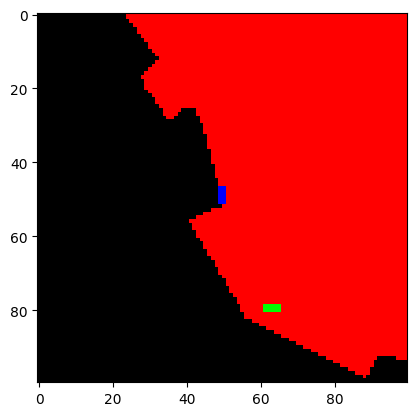

In [4]:
from matplotlib import pyplot as plt
import numpy as np
# display neighborhood image

# get first row of training_data
row = df.iloc[32492]
print(row['filename'])
# load nparray from file
image = np.load('../data/rev-moenk/training/images/'+row['filename'])
# display image
reshaped_image = image.reshape(100,100, 3)
# flip image upside down
reshaped_image = np.flip(reshaped_image, 0)
reshaped_image = np.flip(reshaped_image, 1)
# switch axis to get correct orientation
plt.imshow(np.swapaxes(reshaped_image, 0, 1))

